<hr style="border:2px solid gray"> </hr>

# <center>FakeQuakes Tutorial</center>
## <center>Generates synthetic rupture models and waveforms </center>
### <center>Tara Nye</center>
### <center>PhD Candidate | University of Oregon</center>

<hr style="border:2px solid gray"> </hr>

FakeQuakes is a set of semistochastic foward modeling codes from the github repository [MudPy](https://github.com/dmelgarm/MudPy).  FakeQuakes was created by __Dr. Diego Melgar__ (professor at the Unviersity of Oregon), and the components are outlined in the paper [__Kinematic rupture scenarios and synthetic displacement data: An example application to the Cascadia subduction zone__ (Melgar et al., 2016)](http://doi.wiley.com/10.1002/2016JB013314).  

This set of codes generates synthetic rupture models and can generate low frequency displacement waveforms and broadband acceleration waveforms.

For more information on how to use FakeQuakes, you can refer to this [wiki page](https://github.com/taranye96/tsuquakes/wiki/FakeQuakes-Script) on my github account.  This page walks you through how to set up the parameter file (__.fq.py__) listed in the [tsuquakes](https://github.com/taranye96/tsuquakes) respository and how to run the different steps in FakeQuakes.  If you have any other questions, feel free to contact me or Diego Melgar.

Tara Nye: tnye@uoregon.edu
<br>Diego Melgar: dmelgarm@uoregon.edu

<img src="./figures/rupture_models.png"/>

<br>__Figure 1.__ Mean slip model for the 2010 M7.8 Mentawai event on the left (modified from Yue et al., 2014), and two example synthetic rupture models patterned after this event in the center and on the right.

<hr style="border:1px solid gray"> </hr>

# <center>Table of Contents</center>
## 1. <a href=#installation>FakeQuakes Installation</a>
### &emsp;&emsp;1.1 <a href=#python>Setup Python Environment</a>
### &emsp;&emsp;1.1 <a href=#mudpy>Install MudPy</a>
## 2. <a href=#setup>Project Setup</a>
### &emsp;&emsp;2.1 <a href=#directories>Setup Directories</a>
### &emsp;&emsp;2.2 <a href=#parameters>Define Parameters</a>
## 3. <a href=#generate_ruptures>Generate Rupture Models</a>
## 4. <a href=#LF>Generate Low Frequency Displacement Waveforms</a>
###  &emsp;&emsp;4.1 <a href=#GFs>Compute Green's Functions</a>
### &emsp;&emsp;4.2  <a href=#lf_waveforms>Make Low Frequency Waveforms </a>
## 5. <a href=#BB>Generate Broadband Acceleration Waveforms</a>
### &emsp;&emsp;5.1 <a href=#HF>Make High Frequency Waveforms</a>
### &emsp;&emsp;5.2 <a href=#match_filt>Combine Waveforms</a>
## 5. <a href=#notes>Final Notes</a>
## 6. <a href=#references>References</a>

<a id='installation'></a>
<hr style="border:1px solid gray"> </hr>

# <center>FakeQuakes Installation</center>

<a id='python'></a>
***
## <center>Setup Python Environment</center>
### MudPy requires the following dependencies:
- __ObsPy__ **`$ conda install -c conda-forge obspy`**
- __Pyproj__ **`$ conda install -c conda-forge pyproj`**
- __UTM__ **`$ conda install -c conda-forge utm`**
- __mpi4py__ **`$ conda install -c anaconda mpi4py`**
- __GCC and GFortgran__
    - If you are using a Mac, you can just install __Xcode Developer Tools__ (Apple app store)
    - If you are on a Linux machine:
        **`$ sudo apt install build-essential`**
        **`$ sudo apt-get install gfortran`**

<a id='mudpy'></a>
***
## <center>Install MudPy</center>
### 1. Clone MudPy repository 
**`$ git clone https://github.com/dmelgarm/MudPy.git`**
### 2. Build the fk Green's function code
#### - Inside *MudPy/src/fk/* run:
**`$ make clean`**

**`$ make all`**
### 3. Set Paths (.bash_profile or .bashrc script)
### - Add the Mudpy src/fk folder to your PATH variable 
#### i.e. in my .bash_profile script I have:
**`export PATH=/Users/tnye/code/MudPy/src/fk:$PATH`**
### - Add the Mudpy src/python folder to your PYTHONPATH 
#### i.e. in my .bash_profile script I have:
**`export PYTHONPATH=/Users/tnye/code/MudPy/src/python:$PYTHONPATH`**
### - Define the MUD environment variable
#### i.e. in my .bash_profile script I have:
**`export MUD=/Users/tnye/code/MudPy`**

### 4. Make sure everything worked
#### If you type these into the terminal, a help screen should appear:

**`$ fk.pl`**

**`$ syn`**

<a id='setup'></a>
<hr style="border:1px solid gray"> </hr>

# <center>Project Setup</center>

<a id='directories'></a>
***
## <center>Setup Directories</center>
### In the FakeQuakes_tutorial folder, there is a files folder with these types of files:
- __.gflist__ (list of the stations and their coordinates)
- __.mod__ (velocity profile model for the region where the synthetic scenarios are being generated)
- __.fault__ (fault model with subfault dimensions that will be used to generate the rupture scenarios)

__Note: These are example files, and you will need to create your own for your specific region of study and dataset of stations.__

### __.gflist__

The first three columns are the station name, station longitude, and station latitude. The next five columns are flags for what functions you need depending on the application. If you are just generating low-frequency or high-frequency waveforms, you will only want the "disp" column to have 1's, and the other columns will just be 0's. The final column is an optional column for kappa if you happen to have station-specific kappa values. If not, FakeQuakes will just use a default value of 0.04 s, or you can specify a singular value in the parameters discussed later on. 

In [1]:
!head ./files/sm.gflist

#station  lon lat "static,disp,vel,tsun,strain" kappa
MNSI  99.5796 0.7955  0 1 0 0 0 0.04
PPSI  100.01  -2.7660 0 1 0 0 0 0.04


### __.mod__ 
(Obtained from Yue et al., 2014)

The columns are: Layer thickness(km), Vs(km/s), Vp(km/s), Density(g/cm^3), Qs, and Qp.

Note: The last row has to be a thickness of 0 (it's assumed to be infinite below this).

In [2]:
!head ./files/mentawai.mod

### __.fault__ 
(Modified from Yue et al., 2014)

The columns are: Subfault #, longitude, latitude, depth(km), strike, dip, type (*doesn't do anything*), risetime (*doesn't do anything*), subfault length(m), and subfault width(m).

Note: The columns that don't do anything are left over from slip inversion file setup, but need to be included in the structure of the file.

Note: If you are using a 2D-fault, these subfaults are assumed to be squares, and if you are using a 3D-fault, these subfaults are assumed to be triangles. 

In [3]:
!head ./files/mentawai.fault

1	100.339171	-4.831481	11.258	324.00	8.00	0.5	0.5	7000.00	7000.00
2	100.302071	-4.780277	11.258	324.00	8.00	0.5	0.5	7000.00	7000.00
3	100.264977	-4.729071	11.258	324.00	8.00	0.5	0.5	7000.00	7000.00
4	100.227887	-4.677864	11.258	324.00	8.00	0.5	0.5	7000.00	7000.00
5	100.190803	-4.626655	11.258	324.00	8.00	0.5	0.5	7000.00	7000.00
6	100.153723	-4.575444	11.258	324.00	8.00	0.5	0.5	7000.00	7000.00
7	100.116648	-4.524232	11.258	324.00	8.00	0.5	0.5	7000.00	7000.00
8	100.079578	-4.473018	11.258	324.00	8.00	0.5	0.5	7000.00	7000.00
9	100.042513	-4.421802	11.258	324.00	8.00	0.5	0.5	7000.00	7000.00
10	100.005452	-4.370584	11.258	324.00	8.00	0.5	0.5	7000.00	7000.00


### We need to initialize the project folder and put these files into their respective folders

In [11]:
# Standard Library Imports
import os
import numpy as np
from obspy.core import UTCDateTime
from obspy import read
import time

# MudPy Imports
from mudpy import fakequakes,runslip,forward,view

In [2]:
# Define variables for project location 
home = os.getcwd() + '/' # This sets the current working directory as the home path
project_name='test' # Name of project folder that will be set up in home directory 

If you don't have the dependencies installed, or you want to just use the data I created, set __project_name=demo__

In [3]:
# Initalize project folders
if project_name != 'demo':
    fakequakes.init(home,project_name)

Project directory exists, clobber (y/n)?n
Phew, almost shot yourself in the foot there didn't you?


### Copy the files into these folders 
- __.mod__ should be placed in __*/home/project_name/structure/*__ 
- __.fault__ should be placed in __*/home/project_name/data/model_info/*__
- __.gflist__ file should be placed in __*/home/project_folder/data/station_info/*__

In [2]:
!cp ./files/mentawai.mod $home/$project_name/structure
!cp ./files/mentawai_coarse.fault $home/$project_name/data/model_info
!cp ./files/sm.gflist $home/$project_name/data/station_info

cp: //structure: Read-only file system
cp: //data/model_info: No such file or directory
cp: //data/station_info: No such file or directory


<a id='parameters'></a>

<a id='parameters'></a>
***
## <center>Define Parameters</center>
### Rupture parameters

In [4]:
# Runtime parameters 
ncpus=2                                        # how many CPUS you want to use for parallelization (needs ot be at least 2)
Nrealizations=2                                # Number of fake ruptures to generate per magnitude bin
hot_start=0                                    # If code quits in the middle of running, it will pick back up at this index

# File parameters
model_name='mentawai.mod'                      # Velocity model file name
fault_name='mentawai_coarse.fault'             # Fault model name
mean_slip_name=None                            # Set to path of .rupt file if patterning synthetic runs after a mean rupture model
run_name='mentawai'                            # Base name of each synthetic run (i.e. mentawai.000000, mentawai.000001, etc...)
rupture_list='ruptures.list'                   # Name of list of ruptures that are used to generate waveforms.  'ruptures.list' uses the full list of ruptures FakeQuakes creates. If you create file with a sublist of ruptures, use that file name.
distances_name='mentawai'                      # Name of matrix with estimated distances between subfaults i and j for every subfault pair
load_distances=0                               # This should be zero the first time you run FakeQuakes with your fault model.

In [5]:
# Source parameters
UTM_zone='47M'                                 # UTM_zone for rupture region 
time_epi=UTCDateTime('2010-10-25T14:42:12Z')   # Origin time of event (can set to any time, as long as it's not in the future)
target_Mw=np.array([7.8])                      # Desired magnitude(s), can either be one value or an array
hypocenter=None                                # Coordinates of subfault closest to desired hypocenter, or set to None for random
force_hypocenter=False                         # Set to True if hypocenter specified
rake=90                                        # Average rake for subfaults
scaling_law='T'                                # Type of rupture: T for thrust, S for strike-slip, N for normal
force_magnitude=True                           # Set to True if you want the rupture magnitude to equal the exact target magnitude
force_area=True                                # Set to True if you want the ruptures to fill the whole fault model

In [6]:
# Correlation function parameters
hurst=0.4                                      # Hurst exponent form Melgar and Hayes 2019
Ldip='auto'                                    # Correlation length scaling: 'auto' uses Melgar and Hayes 2019, 'MB2002' uses Mai and Beroza 2002
Lstrike='auto'                                 # Same as above
slip_standard_deviation=0.9                    # Standard deviation for slip statistics: Keep this at 0.9
lognormal=True                                 # Keep this as True to solve the problem of some negative slip subfaults that are produced

In [7]:
# Rupture propagation parameters
rise_time = 'MH2017'                           # Rise time scaling to use. 'GP2010' uses Graves and Pitarka (2010), 'GP2015' uses Graves and Pitarka (2015), 'S1999' uses Sommerville (1999), and 'MH2017' uses Melgar and Hayes (2017).  
rise_time_depths=[10,15]                       # Transition depths for rise time scaling (if slip shallower than first index, rise times are twice as long as calculated)
max_slip=40                                    # Maximum sip (m) allowed in the model
max_slip_rule=False                            # If true, uses a magntidude-depence for max slip
shear_wave_fraction_shallow=0.49               # Shear wave fraction for depths shallower than rise_time_depths[0]
shear_wave_fraction_deep=0.8                   # Shear wave fraction for depths depper than rise_time_depths [1] (0.8 is a standard value (Mai and Beroza 2002))
source_time_function='dreger'                  # options are 'triangle' or 'cosine' or 'dreger'
stf_falloff_rate=4                             # Only affects Dreger STF, 4-8 are reasonable values
num_modes=72                                   # Number of modes in K-L expansion
slab_name=None                                 # Slab 2.0 Ascii file for 3D geometry, set to None for simple 2D geometry
mesh_name=None                                 # GMSH output file for 3D geometry, set to None for simple 2D geometry

### Waveform Parameters

In [8]:
# Green's Functions parameters
GF_list='sm.gflist'                            # Stations file name
G_name='sm'                                    # Basename you want for the Green's functions matrices
make_GFs=1                                     # This should be 1 to run Green's functions
make_synthetics=1                              # This should be 1 to make the synthetics
G_from_file=0                                  # This should be zero the first time you run FakeQuakes with your fault model and stations.

# fk parameters
# used to solve wave equation in frequency domain 
dk=0.1 ; pmin=0 ; pmax=1 ; kmax=20             # Should be set to 0.1, 0, 1, 20
custom_stf=None                                # Assumes specified source time function above if set to None

In [9]:
# Low frequency waveform parameters
dt=0.5                                         # Sampling interval of LF data 
NFFT=512                                       # Number of samples in LF waveforms (should be in powers of 2)
# dt*NFFT = length of low-frequency dispalcement record
# want this value to be close to duration (length of high-frequency record)

# High frequency waveform parameters
stress_parameter=50                            # Stress drop measured in bars (standard value is 50)
moho_depth_in_km=30.0                          # Average depth to Moho in this region 
Pwave=True                                     # Calculates P-waves as well as S-waves if set to True, else just S-Waves
kappa=None                                     # Station kappa values: Options are GF_list for station-specific kappa, a singular value for all stations, or the default 0.04s for every station if set to None
hf_dt=0.01                                     # Sampling interval of HF data
duration=250                                   # Duration (in seconds) of HF record

# Match filter parameters
zero_phase=True                                # If True, filters waveforms twice to remove phase, else filters once
order=4                                        # Number of poles for filters
fcorner_low=0.998                              # Corner frequency at which to filter waveforms (needs to be between 0 and the Nyquist frequency)
fcorner_high=0.01                              # Corner frequency at which to filter waveforms (needs to be between 0 and the Nyquist frequency)

### Whew...we're finally done setting up the parameters

<a id='generate_ruptures'></a>

<a id='generate_ruptures'></a>
<hr style="border:1px solid gray"> </hr>

# <center>Generate Rupture Models</center>
This step uses the __fakequakes.generate_ruptures__ function to generate the different rupture models.  The outputs are .rupt files which are the rupture models with information on each subfault, and .log files which give details on the rupture, such as magntidue, hypocenter, origin time, etc...  Most of this is taken from Mai and Beroza (2002).  
<br>There are two main types of rupture models you can make:
- a rupture model patterned after a real or average rupture model.
- a rupture model with completely random slip patterns

<br> For this tutorial, we will be making random rupture models for the Mentawai region. 

In [26]:
if project_name != 'demo':
    #Generate rupture models
    fakequakes.generate_ruptures(home,project_name,run_name,fault_name,slab_name,mesh_name,load_distances,
        distances_name,UTM_zone,target_Mw,model_name,hurst,Ldip,Lstrike,num_modes,Nrealizations,rake,rise_time,
        rise_time_depths,time_epi,max_slip,source_time_function,lognormal,slip_standard_deviation,scaling_law,
        ncpus,mean_slip_name=mean_slip_name,force_magnitude=force_magnitude,force_area=force_area,
        hypocenter=hypocenter,force_hypocenter=force_hypocenter,shear_wave_fraction_shallow=shear_wave_fraction_shallow,
        shear_wave_fraction_deep=shear_wave_fraction_deep,max_slip_rule=max_slip_rule)   

Building obspy.taup model for '/Users/tnye/FakeQuakes_tutorial/test/structure/mentawai.nd' ...
Extra CPUS-- have 2 free ruptures!!
MPI: Starting 4 FakeQuakes Rupture Generations on  4 CPUs



Bad key text.latex.preview in file /Users/tnye/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/tnye/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /Users/tnye/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc 

Getting inter-fault distances
... working on subfault 0 of 72
Getting inter-fault distances
... working on subfault 0 of 72
Getting inter-fault distances
... working on subfault 0 of 72
Getting inter-fault distances
... working on subfault 0 of 72
... working on subfault 10 of 72
... working on subfault 10 of 72
... working on subfault 10 of 72
... working on subfault 10 of 72
... working on subfault 20 of 72
... working on subfault 20 of 72
... working on subfault 20 of 72
... working on subfault 30 of 72
... working on subfault 20 of 72
... working on subfault 30 of 72
... working on subfault 30 of 72
... working on subfault 30 of 72
... working on subfault 40 of 72
... working on subfault 40 of 72
... working on subfault 40 of 72
... working on subfault 40 of 72
... working on subfault 50 of 72
... working on subfault 50 of 72
... working on subfault 50 of 72
... working on subfault 50 of 72
... working on subfault 60 of 72
... working on subfault 60 of 72
... working on subfault 60

### Rupture Dimensions
<img src="./figures/fault.png" style="width:400px;height:182px"/>
The dimensions of the fault rupture are determined by the target magnitude and rupture dimension scaling laws $\eqref{eq:scaling law length}$$\eqref{eq:scaling law width}$ (Blaser et al., 2010).

\begin{equation*}
log_{10}L = -2.37 + 0.57M_{w}
\label{eq:scaling law length} \tag{1}
\end{equation*}

\begin{equation*}
log_{10}W = -1.86 + 0.46M_{w}
\label{eq:scaling law width} \tag{2}
\end{equation*}

To add some variability in the rupture dimensions of events of the same magnitude, FakeQuakes uses a stochastic approach to the scaling laws $\eqref{eq:stochastic scaling law}$.

\begin{equation*}
log_{10}L \sim N(a_{1} + b_{1}M_{w}, s^{2}_{xy})
\label{eq:stochastic scaling law} \tag{3}
\end{equation*}

### Slip Statistics
<img src="./figures/slip.png" style="width:400px;height:182px"/>

Unless a hypocenter is specified, a random subfault is chosen at the hypocenter.  
<br>The slip on each subfault is normally distributed, and the vector __s__ contains all of the subfault slips $\eqref{eq:slip vector}$.

\begin{equation*}
s \sim N(\mu, \hat{C})
\label{eq:slip vector} \tag{4}
\end{equation*}

<img src="./figures/slip_pdf.png" style="width:440px;height:350px"/>

To produce a synthetic event with the desired magnitude, the mean vector, $\mu$, has uniform slip and enough scalar moment to match the target magnitude we specified $\eqref{eq:moment}$.

\begin{equation*}
M_{0} = \rho LW\mu
\label{eq:moment} \tag{5}
\end{equation*}

$\hat{C}$ is the covariance matrix of the slip distribution and is a function of the standard deviation of slip at each subfault and the correlation between each ith and jth subfault pair.  FakeQuakes uses the __Von Karman correlation function__ $\eqref{eq:correlation function}$ because it represents fault slip patterns well. 

\begin{equation*}
C_{ij}(r_{ij}) = \frac{G_H(r_{ij})}{G_0(r_{ij})}
\label{eq:correlation function} \tag{6}
\end{equation*}

\begin{equation*}
G_{H} = r^{H}_{ij}K_{H}(r_{ij})
\label{eq:GH} \tag{7}
\end{equation*}

- r$_{ij}$ is a length measure between subfaults i and j<br>(__Note__: This is not the actual distance.  It is a value dependent on the along strike and along dip distances between subfaults)
- __H__ is the hurst exponent that we defined in the parameters
- K$_{H}$ is the modified Bessel function of the second kind
    - solution to Bessel differential equation which is used when solving the 3D wave equation

If $\lambda$$_{k}$ and v$_{k}$ are the eigenvalues and eigenvectors of the correlation function C$_{ij}$, then the slip vector, s, can be expressed by the __Karhunen Loeve (K-L) expansion__ $\eqref{eq:K-L expansion}$.  

\begin{equation*}
s = \mu + \sum\limits_{k=1}^N z_{k}\sqrt{\lambda_{k}v_{k}}
\label{eq:K-L expansion} \tag{8}
\end{equation*}

- N is the number of modes specified, and it can be any number up to the number of subaults in your mode.  The more modes you have, the better you can model the high frequency stuff, but it also takes longer to compute. 
- z$_{k}$ are normally distrubuted random numbers between 0-1 that are used as weights for each eigenmode. This is what gives some randomness to the slip patterns.


### Kinematics 
<img src="./figures/rupture.gif" style="width:400px;height:182px"/>
Now that we have the static slip distribution, we need to determine the kinematics of the rupture so that we can generate the waveforms.  

The rupture onset time of each subfault is determined __(2-stage)__
1. Background rupture distribution $\eqref{eq:Vrupt}$ is determined using the shear-wave speed from the velocity model (V$_{s}$) and the shear-wave fraction parameter we set (SF)
\begin{equation*}
V_{r} = (SF)(V_{s})
\label{eq:Vrupt} \tag{9}
\end{equation*}
    - There is a reduction in rupture speed at shallow depths, as represented by the small shear_wave_fraction_shallow compared to shear_wave_fraction_deep.  This is to account for the low shear-wave velocity at shallow depths in the accretionary wedge.
    - Subfault onset times from this background distribution are perturbed so that there's faster propagation where slip is large (Graves and Pitarka, 2010).
    - Risetime of each subfault (duration of slip) scaled by __√__(total slip on subfault) so that larger slips have longer risetimes
2. A slip rate function is applied to determine how the slip evolved over time. 


### Output 
This step results in two output file types: .log and .rupt files. 
- .log file: A file for one run containing the overall parameters of the rupture (e.g. Project name, earthquake magnitude and coordinates, etc..)
- .rupt file: A file for one run containing the kinematics of the rupture (e.g. slip on each subfault, rupture onset time, slip duration, etc...)

### View .log file

In [27]:
logpath=os.getcwd() +'/' + project_name + '/output/ruptures/mentawai.000000.log'
var=!cat $logpath
var

['Scenario calculated at 2022-09-19 22:39:06 GMT',
 'Project name: test',
 'Run name: mentawai',
 'Run number: 000000',
 'Velocity model: mentawai.mod',
 'No. of KL modes: 72',
 'Hurst exponent: 0.4',
 'Corr. length used Lstrike: 62.92 km',
 'Corr. length used Ldip: 32.30 km',
 'Slip std. dev.: 0.900 km',
 'Maximum length Lmax: 156.48 km',
 'Maximum width Wmax: 75.00 km',
 'Effective length Leff: 133.01 km',
 'Effective width Weff: 63.75 km',
 'Target magnitude: Mw 7.8000',
 'Actual magnitude: Mw 7.8000',
 'Hypocenter (lon,lat,z[km]): (100.291000,-3.697000,11.82)',
 'Hypocenter time: 2010-10-25T14:42:12.000000Z',
 'Centroid (lon,lat,z[km]): (99.792568,-3.321659,9.16)',
 'Source time function type: dreger',
 'Average Risetime (s): 5.363082720e+00',
 'Average Rupture Velocity (km/s): 1.719570406e+00',
 'Avg. length: 0.00 km',
 'Avg. width: 0.00 km',
 'Class: 0 type']

### View .rupt file

In [28]:
ruptpath=f'{home}/{project_name}/output/ruptures/mentawai.000000.rupt'
!head $ruptpath

# No,lon,lat,z(km),strike,dip,rise,dura,ss-slip(m),ds-slip(m),ss_len(m),ds_len(m),rupt_time(s),rigidity(Pa),velocity(km/s)
1	 99.933000	 -4.115000	  3.9880	 324.00	   7.50	 0.0	6.964568196e+00	7.3502e-02	2.3730e+00	  14250.00	  15000.00	3.496457099e+01	1.934300e+10	1.758102e+00
2	100.041000	 -4.037000	  5.9460	 324.00	   7.50	 0.0	3.172811163e+00	4.3362e-02	4.0572e-01	  14250.00	  15000.00	3.226792138e+01	3.112616e+10	1.459860e+00
3	100.150000	 -3.958000	  7.9040	 324.00	   7.50	 0.0	3.352092856e+00	7.9603e-02	4.1914e-01	  14250.00	  15000.00	2.381389846e+01	3.112616e+10	1.388655e+00
4	100.258000	 -3.880000	  9.8620	 324.00	   7.50	 0.0	3.072240397e+00	-3.1702e-02	3.7591e-01	  14250.00	  15000.00	1.693449545e+01	3.112616e+10	1.219894e+00
5	100.366000	 -3.801000	 11.8200	 324.00	   7.50	 0.0	4.119162729e+00	1.3545e-01	9.2539e-01	  14250.00	  15000.00	9.714043087e+00	3.307500e+10	1.461889e+00
6	100.475000	 -3.722000	 13.7780	 324.00	   7.50	 0.0	3.531143330e+00	1.0332e-01	1.0011e+00	  14

### Quick view of the rupture models: Coarse Fault Model

We are using a coarse (large subfaults) fault model for this tutorial to save computation time.

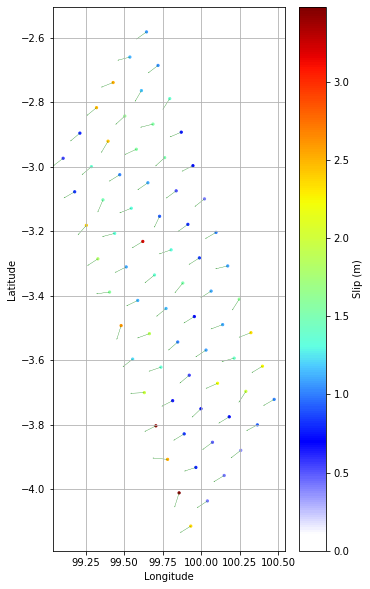

In [29]:
%matplotlib inline
#%matplotlib notebook
view.quick_model(f'{home}/{project_name}/output/ruptures/mentawai.000000.rupt')

### Quick view of example rupture models: Fine Fault Model

This is an example of what are more fine-scale resolution (smaller subfaults) fault model would look like.

/Users/tnye/code/MudPy/src/python/mudpy/view.py:2909: RuntimeWarning: invalid value encountered in true_divide
  ds=ds/((ds**2+ss**2)**0.5)


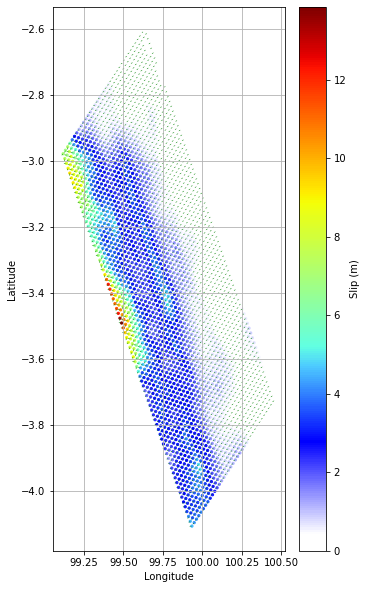

In [30]:
%matplotlib inline
#%matplotlib notebook
view.quick_model(f'{os.getcwd()}/figures/mentawai_fine.000000.rupt')

<a id='LF'></a>
<hr style="border:1px solid gray"> </hr>

# <center>Generate Low Frequency Displacement Waveforms</center>

<a id='GFs'></a>
***
## <center>Compute Green's Functions</center>
This step uses the __runslip.inversion__ function to generate the Green's Functions, which are seismograms for each subfault-station pair...one step closer to getting the final waveforms!  This uses the frequency-waveform (fk) integration code from Zhu and Rivera (2002).

In [31]:
if project_name != 'demo':
    # I'm increasing the ncpus here to speed up computation time. If I had set ncpus to 4 initially, it would have tried to make 4 rupture models.
    ncpus=4  
    runslip.inversionGFs(home,project_name,GF_list,None,fault_name,model_name,
        dt,None,NFFT,None,make_GFs,make_synthetics,dk,pmin,
        pmax,kmax,0,time_epi,hot_start,ncpus,custom_stf,impulse=True) 

Displacememnt GFs requested...
MPI: Starting GFs computation on 4 CPUs

mpiexec -n 4 python /Users/tnye/code/MudPy/src/python/mudpy/parallel.py run_parallel_green /Users/tnye/FakeQuakes_tutorial/ test /Users/tnye/FakeQuakes_tutorial/test/data/station_info/temp.sta mentawai.mod 0.5 512 0 0.1 0 1 20 False False
Running all processes with:
        home = /Users/tnye/FakeQuakes_tutorial/
        project_name = test
        station_file = /Users/tnye/FakeQuakes_tutorial/test/data/station_info/temp.sta
        model_name = mentawai.mod
        static = 0
        tsunami = False
        dt = 0.500
        NFFT = 512
        dk = 0.100
        pmin = 0.000
        pmax = 1.000
        kmax = 20.000
        insar = False
        
MPI: processor # 2 is now working on subfault 3 ( 1 / 18 )
MPI: processor # 0 is now working on subfault 1 ( 1 / 18 )
MPI: processor # 3 is now working on subfault 4 ( 1 / 18 )
MPI: processor # 1 is now working on subfault 2 ( 1 / 18 )
MPI: processor # 3 is now working

Processor 2 is working on subfault 47 and 2 stations 
Processor 1 is working on subfault 46 and 2 stations 
Processor 0 is working on subfault 45 and 2 stations 
Processor 3 is working on subfault 48 and 2 stations 
Processor 0 is working on subfault 49 and 2 stations 
Processor 2 is working on subfault 51 and 2 stations 
Processor 1 is working on subfault 50 and 2 stations 
Processor 3 is working on subfault 52 and 2 stations 
Processor 1 is working on subfault 54 and 2 stations 
Processor 2 is working on subfault 55 and 2 stations 
Processor 0 is working on subfault 53 and 2 stations 
Processor 3 is working on subfault 56 and 2 stations 
Processor 1 is working on subfault 58 and 2 stations 
Processor 2 is working on subfault 59 and 2 stations 
Processor 0 is working on subfault 57 and 2 stations 
Processor 3 is working on subfault 60 and 2 stations 
Processor 1 is working on subfault 62 and 2 stations 
Processor 2 is working on subfault 63 and 2 stations 
Processor 0 is working on su

### Green's Functions (GFs)
Green's functions are what the seismogram would look like for 1 meter of displacement, assuming a delta source.   
<br> To calculate the GFs, we assume a layered half-space model and use a propagator matrix, which is what we use to go from stress changes along the fault to displacement at the surface.
<img src="./figures/half_space.png"/>
<br>__Figure 2.__ Half-space model from Zhu and Rivera, 2002.

### Synthetics
The GFs provide the static displacement, but we need to know how displcement evolved over time.  To obtain this, we convolve the GFs (*G*(*t*)) with a STF (*X*(*t*)) $\eqref{eq:synthetic}$.  FakeQuakes refers to these products as synthetics (*S*(*t*)).
 
\begin{equation*}
S(t) = X(t)\circledast G(t)
\label{eq:synthetic} \tag{9}
\end{equation*}

<img src="./figures/subfault_seismograms.png" style="width:400px;height:250px"/>

<br>__Figure 3.__ Example subfault seismograms for one station (blue triangle).

<a id='lf_waveforms'></a>
***
## <center>Make Low Frequency Waveforms</center>

We can use the __waveforms_fakequakes__ function to get the displacement waveforms at the different stations in our stations file using the synthetics we obtained in the last step.  

In [32]:
if project_name != 'demo':
    #Make low frequency waveforms
    forward.waveforms_fakequakes(home,project_name,fault_name,rupture_list,GF_list,
                model_name,run_name,dt,NFFT,G_from_file,G_name,source_time_function,
                stf_falloff_rate)

Solving for kinematic problem(s)
... loading all synthetics into memory
... ... reading green functions for station #1 of 2
... ... reading green functions for station #2 of 2
... done, writting synthetics to miniSEED, hang on this might take a minute or two.
... ... ... done
... reading epicentral time from log file. REMEMBER: All ruptures in ruptures.list should have a common epicentral time
... broadcast to G matrix
... ... done
... clean up: removing obspy streams from memory
... ... done
... solving for source 0 of 4: mentawai.000000.rupt
384.04516442473886
0.5
7.535925771392926
0.5
9.919608483569023
0.5
6.414936139525377
0.5
27.794376373339087
0.5
12.867383847540502
0.5
1543.1837609993124
0.5
67.80814941207056
0.5
5.776271699141682
0.5
36.666880509508175
0.5
172.53300998803778
0.5
64.21963937324008
0.5
994.9072531052199
0.5
71.2538228871795
0.5
14.80644281102106
0.5
465.63505632313706
0.5
55.887418172505946
0.5
108.46299515918601
0.5
1286.1516876985497
0.5
30.06530772814157
0.5
4

The generation of LF waveforms is deterministic, which means it is based off of our understanding of how seismic waves propagate through a media.  This is done using a 1D velocity model and GFs.

The GFs assume slip of 1 m, so we have to scale them to match the actual slip on the fault by multiplying each synthetic by the slip on that subfault.  The final waveforms for each station are the sum of the subfault synthetics associated with the station.

***
## Results...Finally!!

### Read in two of the displacement waveforms

The 'LY' channel code refers to low-frequency displacement waveforms.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


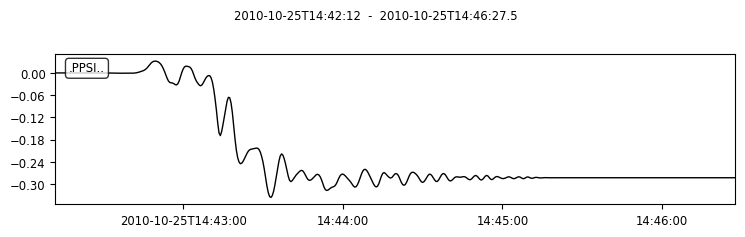

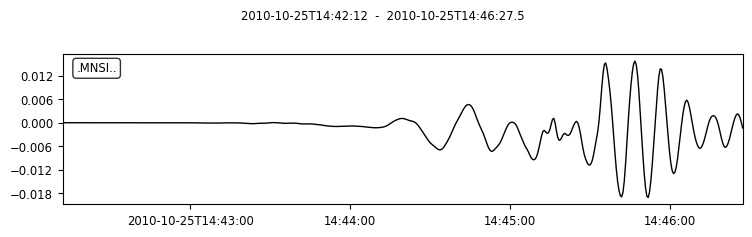

In [33]:
st1 = read(f'{home}/{project_name}/output/waveforms/mentawai.000000/PPSI.LYE.sac')
tr1 = st1[0]
st2 = read(f'{home}/{project_name}/output/waveforms/mentawai.000000/MNSI.LYE.sac')
tr2 = st2[0]

tr1.plot()
tr2.plot()

PPSI has a static offset (final displacement does not equal initial) because it is closer to the source.

<a id='BB'></a>
<hr style="border:1px solid gray"> </hr>

# <center>Generate Broadband Acceleration Waveforms</center>

<a id='HF'></a>
***
## <center>Make High Frequency Waveforms</center>
We can use the __hf_waveforms__ function to get the high frequency acceleration waveforms at the different stations in our stations file.  Most of this is taken from Graves and Pitarka (2010, 2015).

In [16]:
if project_name != 'demo':    
    # Make high-frequency waveforms
    forward.hf_waveforms(home,project_name,fault_name,rupture_list,GF_list,
                    model_name,run_name,dt,NFFT,G_from_file,G_name,rise_time_depths,
                    moho_depth_in_km,ncpus,source_time_function=source_time_function,
                    duration=duration,stf_falloff_rate=stf_falloff_rate,hf_dt=hf_dt,
                    Pwave=Pwave,hot_start=hot_start,stress_parameter=stress_parameter)

... solving HF waveforms for source 0 of 4
MPI: Starting Stochastic High Frequency Simulation on  2 CPUs
Running with input parameters:
        home = /Users/tnye/FakeQuakes_tutorial/
        project_name = test
        rupture_name = mentawai.000000.rupt
        N = 72
        M0 (N-m) = 6.309573433832891e+20
        sta = MNSI
        sta_lon = 99.5796
        sta_lat = 0.7955
        model_name = mentawai.mod
        rise_time_depths = [10, 15]
        moho_depth_in_km = 30.0
        total_duration = 250
        hf_dt = 0.01
        stress_parameter = 50.0
        kappa = 0.04
        Qexp = 0.6
        component = N
        Pwave = True
        Swave = True
        high_stress_depth = 10000.0
        Qmethod = shallowest
        scattering = off
        Qc_exp = 0.0
        baseline_Qc = 100.0
        

        Rupture_Name = mentawai.000000.rupt
        Station = MNSI
        Component (N,E,Z) = N
        Sample rate = 100.0Hz
        Duration = 250s
        
      [....]
MPI: Sta


        Rupture_Name = mentawai.000002.rupt
        Station = PPSI
        Component (N,E,Z) = E
        Sample rate = 100.0Hz
        Duration = 250s
        
      [....]
MPI: Starting Stochastic High Frequency Simulation on  2 CPUs

        Rupture_Name = mentawai.000002.rupt
        Station = PPSI
        Component (N,E,Z) = Z
        Sample rate = 100.0Hz
        Duration = 250s
        
      [....]
... solving HF waveforms for source 3 of 4
MPI: Starting Stochastic High Frequency Simulation on  2 CPUs
Running with input parameters:
        home = /Users/tnye/FakeQuakes_tutorial/
        project_name = test
        rupture_name = mentawai.000003.rupt
        N = 72
        M0 (N-m) = 6.309572363107883e+20
        sta = MNSI
        sta_lon = 99.5796
        sta_lat = 0.7955
        model_name = mentawai.mod
        rise_time_depths = [10, 15]
        moho_depth_in_km = 30.0
        total_duration = 250
        hf_dt = 0.01
        stress_parameter = 50.0
        kappa = 0.04
   

The generation of HF waveforms is done stochastically.  This means that there is some randomness to the process, but it is based off of probability distributions.  It would be computationally-expensive to run the HF part determinisitically and would require a much more detailed model of the subsurface.  
<br>This step works in the frequency domain to generate the waveforms.  Each subfault contributes an acceleration amplitude spectrum for each station $\eqref{eq:hf_spectra}$.

\begin{equation*}
A_{i}(f) = \sum\limits_{j=1,M} C_{ij}S_{i}(f)G_{ij}(f)P(f)
\label{eq:hf_spectra} \tag{10}
\end{equation*}

- C$_{ij}$ is the radiation scale factor
- S$_{i}$(f) is the source radiation spectrum for subfault *i*
- G$_{ij}$(f) is the path term, which accounts for intrinsic attenuation along the path
- P(f) is the high-frequency spectral decay from site effects

To add some "randomness", the spectra are combined with the random phase of a Gaussian white noise time series.  <br>Then the spectra are Fourier-transformed back into the time domain, giving an acceleration time series for each subfault-station pair. 
<br>As with the low-frequencies, all of the subfault seismograms for each station are then summed up to produce the final waveforms for each station. 

### Read in two of the acceleration waveforms

The 'HN' channel code refers to high-frequency acceleration waveforms.


Bad key text.latex.preview in file /Users/tnye/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/tnye/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/tnye/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality p

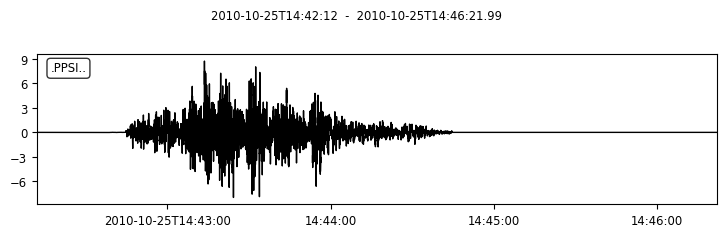

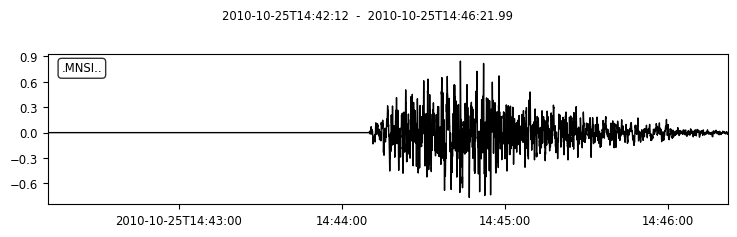

In [17]:
st1 = read(f'{home}/{project_name}/output/waveforms/mentawai.000000/PPSI.HNE.mpi.sac')
tr1 = st1[0]
st2 = read(f'{home}/{project_name}/output/waveforms/mentawai.000000/MNSI.HNE.mpi.sac')
tr2 = st2[0]

tr1.plot()
tr2.plot()

<a id='match_filt'></a>
***
## <center>Combine Waveforms</center>
We can use the __match_filter__ function to combine the low frequency and high frequency waveforms to get final broadband waveforms for the stations in our station file. 

In [18]:
if project_name != 'demo':
    # Combine LF and HF waveforms with match filter                              
    forward.match_filter(home,project_name,fault_name,rupture_list,GF_list,zero_phase,order,
                         fcorner_high=fcorner_high,fcorner_low=fcorner_low)

Running matched filter for all stations for rupture mentawai.000000.rupt
Running matched filter for all stations for rupture mentawai.000001.rupt
Running matched filter for all stations for rupture mentawai.000002.rupt
Running matched filter for all stations for rupture mentawai.000003.rupt


* The LF displacement waveforms are double-differentiated into acceleration waveforms.
* The LF waveforms are resampled to have same sampling rate as the HF waveforms.
* The LF and HF waveforms are trimmed to have the same length.
* The LF waveforms are lowpass filtered and the HF waveforms are highpass filtered.
* The LF and HF waveforms are added together to get final broadband waveforms. 

<img src="./figures/match_filter_time.png"/>

<br>__Figure 3.__ Example low frequency and high frequency acceleration waveforms before filtering (left) and after filtering (right).  The final broadband waveforms is a sum of the two filtered waveforms.
<img src="./figures/match_filter.png"/>

<br>__Figure 4.__ Example low frequency and high frequency acceleration Fourier amplitude spectra before filtering (left) and after filtering (right).  The final broadband waveforms is a sum of the two filtered waveforms.

### Read in two of the broadband acceleration waveforms

The 'bb.HN' channel code refers to broadband acceleration waveforms.

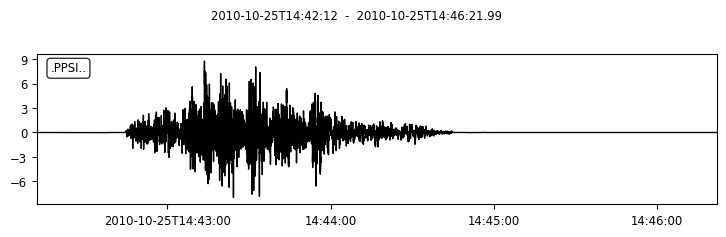

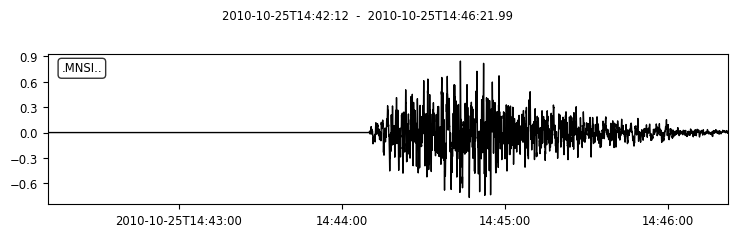

In [19]:
st1 = read(f'{home}/{project_name}/output/waveforms/mentawai.000000/PPSI.bb.HNE.sac')
tr1 = st1[0]
st2 = read(f'{home}/{project_name}/output/waveforms/mentawai.000000/MNSI.bb.HNE.sac')
tr2 = st2[0]

tr1.plot()
tr2.plot()

<a id='notes'></a>
<hr style="border:1px solid gray"> </hr>

# <center> Final Notes </center>
* All rupture files are stored in __/output/ruptures/__
* All waveforms are stored in __/output/waveforms/__
    * __.LY*.sac__ files are the low-frequency displacement files
    * __.HN*mpi.sac__ files are the high-frequency acceleration files
    * __.bb.HN*.sac__ files are the final broadband acceleration waveforms

<a id='references'></a>
<hr style="border:1px solid gray"> </hr>

### References
Blaser, L., F. Krüger, M. Ohrnberger, and F. Scherbaum (2010), Scaling relations of earthquake source parameter estimates with special focus on subduction environment, Bull. Seism. Soc. Am., 100, 2914–2926.

Graves, R., and A. Pitarka (2015), Refinements to the Graves and Pitarka (2010) broadband ground-motion simulation method, Seismol. Res. Lett., 86(1), 75–80.

Graves, R. W., & Pitarka, A. (2010), Broadband Ground-Motion Simulation Using a Hybrid Approach. Bulletin of the Seismological Society of America, 100(5A), 2095-2123. doi:10.1785/0120100057

Mai, P. M., and Beroza, G. C. (2002), A spatial random field model to characterize complexity in earthquake slip, J. Geophys. Res., 107(B11), 2308, doi:10.1029/2001JB000588

Melgar, D., Leveque, R. J., Dreger, D. S., & Allen, R. M. (2016), Kinematic rupture scenarios and synthetic displacement data: An example application to the Cascadia subduction zone. Journal of Geophysical Research: Solid Earth, 121(9), 6658-6674, doi:10.1002/2016jb013314

Yue, H., Lay, T., Rivera, L., Bai, Y., Yamazaki, Y., Cheung, K. F., … Muhari, A. (2014), Rupture process of the 2010 Mw 7.8 Mentawai tsunami earthquake from joint inversion of near-field hr-GPS and teleseismic body wave recordings constrained by tsunami observations. AGU: Journal of Geophysical Research, Solid Earth, 119, 5574–5593, doi:10.1002/2014JB011082

Zhu, L., & Rivera, L. A. (2002), A note on the dynamic and static displacements from a point source in multilayered media. Geophysical Journal International, 148(3), 619-627, doi:10.1046/j.1365-246x.2002.01610.x